In [2]:
import skorch
import torch
import torch.nn as nn

from math import ceil
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from sine_data import train_dataset, valid_dataset

In [5]:
X_train, y_train = train_dataset(points=200)
X_train, y_train = torch.Tensor(X_train), torch.LongTensor(y_train)

X_valid, y_valid = valid_dataset(points=400)
X_valid, y_valid = torch.Tensor(X_valid), torch.LongTensor(y_valid)

sine_train_loader = DataLoader(TensorDataset(X_train, y_train),
                               batch_size=64,
                               shuffle=True)
sine_valid_loader = DataLoader(TensorDataset(X_valid, y_valid),
                               batch_size=64,
                               shuffle=False)

In [6]:
class ClipBPTTWrapper(nn.Module):
    def __init__(self, rnn_layer, hidden_dim, time_steps):
        super().__init__()
        self.rnn_layer = rnn_layer
        self.hidden_dim = hidden_dim
        self.time_steps = time_steps
        
    def init_hidden(self, batch_size, use_cuda):
        v = Variable(torch.zeros(self.hidden_dim, batch_size, self.hidden_dim))
        return v.cuda() if use_cuda else v
    
    def repack(self, h):
        v = Variable(h.data)
        return v.cuda() if h.is_cuda else v
    
    def rnn(self, x, h):
        return self.rnn_layer(x, h)
        
    def forward(self, x):
        num_steps = ceil(x.size(1) / self.time_steps)
        chunks = torch.chunk(x, num_steps, dim=1)
        h = self.init_hidden(x.size(0), x.is_cuda)
        ys = []
        
        for chunk in chunks:
            h = self.repack(h) # limit backprop to one chunk
            y, h = self.rnn(chunk, h)
            ys.append(y[:,-1])
        return torch.stack(ys, dim=1), h

In [11]:
def time_flatten(t):
    return t.view(t.size(0) * t.size(1), -1)

def time_unflatten(t, s):
    return t.view(s[0], s[1], -1)

In [31]:
class RepeatingRNN(nn.Module):
    def __init__(self, rnn_layer):
        super().__init__()
        self.rnn_layer = rnn_layer
        
    def forward(self, x, target_length):
        repeats = ceil(target_length / x.size(1))
        x = x.repeat(1, repeats, 1)
        y, h = self.rnn_layer(x)
        return y[:, :target_length], h

In [32]:
class ReconModel(nn.Module):
    def __init__(
        self, 
        num_hidden=16, 
        num_timesteps_per_chunk_0=20, 
        num_timesteps_per_chunk_1=2, 
        baseline=False,
    ):
        super().__init__()
        
        # t -> ceil(t/20) timesteps
        layer_0 = nn.GRU(1, num_hidden, batch_first=True)
        self.rnn_enc_0 = ClipBPTTWrapper(layer_0, num_hidden, num_timesteps_per_chunk_0)
        
        # ceil(t/20) -> ceil(ceil(t/20)/2) timesteps
        layer_1 = nn.GRU(num_hidden, num_hidden, batch_first=True)
        self.rnn_enc_1 = ClipBPTTWrapper(layer_1, num_hidden, num_timesteps_per_chunk_1)
        
        # ceil(ceil(t/20)/2) chunks total as hidden repr. (3 for t=100)
        # so we now want 3 -> 100 again (recon task)
        # we do this by generating 100//3 for each chunk
        layer_2 = nn.GRU(num_hidden, num_hidden)
        self.rnn_dec_1 = RepeatingRNN(layer_2)
        
        self.clf = nn.Linear(num_hidden, 1)
        
    def forward(self, x):
        l0, h0 = self.rnn_enc_0(x)
        l1, h1 = self.rnn_enc_1(l0)
        l2, h2 = self.rnn_dec_1(l1, x.size(1))
        clf = self.clf(l2)
        return time_unflatten(clf, x.size())

In [33]:
class Trainer(skorch.NeuralNet):
    def __init__(self, 
                 criterion=nn.MSELoss,
                 *args, 
                 **kwargs):
        super().__init__(*args, criterion=criterion, **kwargs)

    def get_loss(self, y_pred, y_true, X=None, train=False):
        pred = time_flatten(y_pred)
        true = time_flatten(y_true)
        return super().get_loss(pred, true, X=X, train=train)

## with clip

In [47]:
torch.manual_seed(1337)

def my_train_split(X, y):
    return X, X_valid[:, :-1], y, X_valid[:, 1:]

ef_with = Trainer(module=ReconModel,
             optimizer=torch.optim.Adam,
             lr=0.005,
             max_epochs=60,
             train_split=my_train_split,
             
             module__num_hidden=16,
             module__num_timesteps_per_chunk_0=50,
             module__num_timesteps_per_chunk_1=10,
            )

In [48]:
%pdb on
ef_with.fit(X_train[:, :-1], X_train[:, 1:])

Automatic pdb calling has been turned ON
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.9025        1.7601  0.3608
      2        1.7907        1.6653  0.3701
      3        1.6825        1.5680  0.5434
      4        1.5721        1.4652  0.3794
      5        1.4557        1.3562  0.4181
      6        1.3322        1.2429  0.3267
      7        1.2034        1.1297  0.3430
      8        1.0743        1.0247  0.4004
      9        0.9547        0.9388  0.3606
     10        0.8578        0.8825  0.3515
     11        0.7967        0.8605  0.4610
     12        0.7769        0.8663  0.3554
     13        0.7890        0.8842  0.3409
     14        0.8124        0.8987  0.4511
     15        0.8294        0.9021  0.3351
     16        0.8324        0.8934  0.3668
     17        0.8214        0.8754  0.3752
     18        0.8004        0.8519  0.3705
     19        0.7741        0.8267  0.4432
     20        0.7473        0.8028

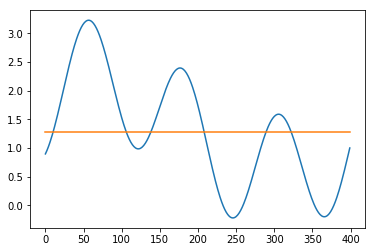

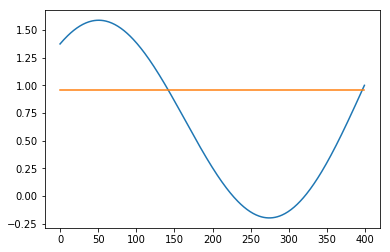

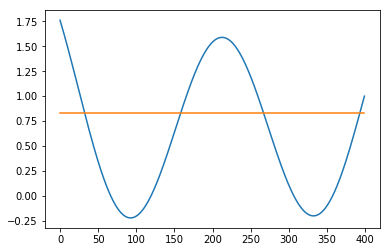

In [49]:
data = X_valid
pred = ef_with.predict_proba(data)

for i in range(pred.shape[0]):
    plt.figure(i)
    plt.plot(data[i].numpy())
    plt.plot(np.arange(len(pred[i])), pred[i])

## without clip (baseline)

In [99]:
torch.manual_seed(1337)

def my_train_split(X, y):
    return X, X_valid[:, :-1], y, X_valid[:, 1:]

ef_base = Trainer(module=ReconModel,
             optim=torch.optim.Adam,
             lr=0.005,
             max_epochs=30,
             train_split=my_train_split,
             
             module__num_hidden=64,
             module__num_timesteps_per_chunk=20,
             module__baseline=True,
            )

In [100]:
%pdb on
ef_base.fit(X_train[:, :-1], X_train[:, 1:])

Automatic pdb calling has been turned ON
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.2364        0.9778  0.4214
      2        0.9866        0.7472  0.3568
      3        0.7527        0.5204  0.4128
      4        0.5238        0.3141  0.3401
      5        0.3170        0.2111  0.3390
      6        0.2180        0.3155  0.3810
      7        0.3321        0.2481  0.3482
      8        0.2603        0.1543  0.4746
      9        0.1595        0.1197  0.4359
     10        0.1209        0.1211  0.3357
     11        0.1206        0.1286  0.5007
     12        0.1278        0.1266  0.3972
     13        0.1262        0.1107  0.3323
     14        0.1110        0.0834  0.3292
     15        0.0847        0.0520  0.5117
     16        0.0548        0.0269  0.3325
     17        0.0321        0.0182  0.3368
     18        0.0271        0.0257  0.3864
     19        0.0387        0.0317  0.3347
     20        0.0472        0.0235

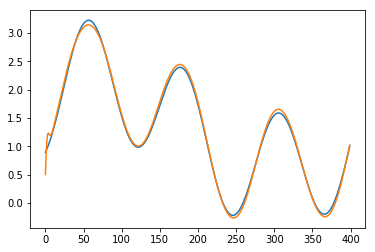

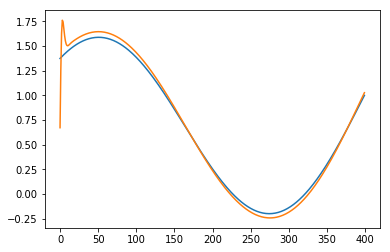

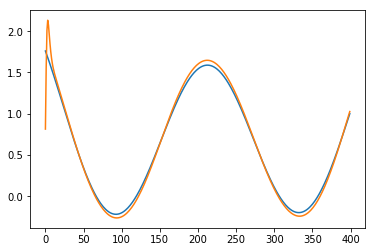

In [101]:
data = X_valid
pred = ef_base.predict_proba(data)

for i in range(pred.shape[0]):
    plt.figure(i)
    plt.plot(data[i].numpy())
    plt.plot(np.arange(len(pred[i])), pred[i])